In [1]:
import pandas as pd
import numpy as np

In [2]:
fill_df = pd.read_csv("fullMnist.csv", index_col=0)

In [3]:
class TimsLDAClassifier:

    def __init__(self, df: pd.DataFrame):
        # td is training data
        self.td = df
        self.classes = np.sort(self.td.label.unique()).tolist()
        self.num_samples, self.sample_size = self.td.shape
        # subtract 1 from sample size to not count label
        self.sample_size -= 1

    def sortDataByClass(self):
        self.td = self.td.sort_values(by=['label'])

    def buildClassMeans(self):        
        # Allocate array with the correct size - (sample_size) x classes
        self.means = np.zeros(shape=(len(self.classes), self.sample_size)) 
        for clazz in self.classes:
            self.means[self.classes.index(clazz)] = self.meanForClass(clazz)
        
    def meanForClass(self, clazz):
        classSubset = self.td.loc[self.td['label'] == clazz].drop(columns='label').to_numpy()
        classSubset = np.sum(classSubset, axis=0) / classSubset.shape[0]
        return classSubset

    def buildProjectedClassMeans(self):
        self.projectedMeans = np.zeros(shape=(len(self.classes), self.lowerDimension))
        for clazz in self.classes:
            self.projectedMeans[self.classes.index(clazz)] = self.projectedMeanForClass(clazz)

    def withinClassCovarianceForClass(self, clazz):
        temp = np.zeros(shape=(self.sample_size, self.sample_size))
        classSubset = self.td.loc[self.td['label'] == clazz].drop(columns='label').to_numpy()
        for row in classSubset:
            curRow = np.subtract(row, self.means[self.classes.index(clazz)])
            curRow = np.outer(np.transpose(curRow), curRow)
            temp += curRow
        return temp
        
    def withinClassCovariance(self):
        swCovariance = np.zeros(shape=(self.sample_size, self.sample_size))
        for clazz in self.classes:
            swCovariance += self.withinClassCovarianceForClass(clazz)
        self.sw = swCovariance

    def betweenClassCovariance(self):
        sbCovariance = np.zeros(shape=(self.sample_size, self.sample_size))
        globalMean = np.sum(self.means, axis=0)
        for clazz in self.classes:
            temp = np.subtract(self.means[self.classes.index(clazz)], globalMean)
            temp = np.outer(np.transpose(temp), temp)
            # Scale by the number of samples of this class
            temp = temp * self.td[self.td['label'] == clazz].shape[0]
            sbCovariance += temp
        self.sb = sbCovariance

    def getSortedEigens(self):
        weightMatrix = np.matmul(np.linalg.pinv(self.sw), self.sb)
        eigenValues, self.eigenVectors = np.linalg.eig(weightMatrix)
        # Transpose the eigenVectors because of the way it returns and the way I am indexing it
        self.eigenVectors = np.transpose(self.eigenVectors)        
        # Add index for each eigenvalue so that it can be correllated to its eigenvector after a sort
        eigenValues = np.c_[eigenValues, range(0, eigenValues.shape[0])]
        # Sort the eigenValues largest first
        self.sortedEigenValues = np.flip(eigenValues[eigenValues[:,0].argsort()], axis=0)

    def createMapToLowerDimensionality(self, lowerDimension: int):
        self.lowerDimension = lowerDimension
        self.w = np.zeros(shape=(lowerDimension, self.sample_size), dtype=np.complex128)
        for i in range(0, lowerDimension):
            self.w[i] = self.eigenVectors[int(self.sortedEigenValues[i][1].real)]
        self.w = np.transpose(self.w)

    def projectDataToLowerDimension(self):
        self.projectedData = np.matmul(self.td.drop(columns='label').to_numpy(), self.w)

    #TODO: re-write
    def gaussian(self):
        # get projected means
        self.projectedMeans = np.zeros(shape=(len(self.classes), self.lowerDimension))
        self.projectedCov = np.zeros(shape=(len(self.classes), self.lowerDimension, self.lowerDimension))
        self.projectedPriors = np.zeros(shape=(len(self.classes), self.lowerDimension))
        for clazz in self.classes:
            indexForClass = self.classes.index(clazz)
            self.projectedMeans[indexForClass], self.projectedCov[indexForClass], self.projectedPriors[indexForClass] = self.guassianForClass(clazz)

    # rewrite?
    def guassianForClass(self, clazz):
        classSubset = self.td.loc[self.td['label'] == clazz].drop(columns='label').to_numpy()
        numSamplesForClass = classSubset.shape[0]
        projectedClassSubset = np.matmul(classSubset, self.w).real
        classSubsetMeans = np.sum(projectedClassSubset, axis=0) / numSamplesForClass
        classSubsetCov = np.cov(projectedClassSubset, rowvar=False)
        classSubsetPriors = numSamplesForClass / self.num_samples
        return classSubsetMeans, classSubsetCov, classSubsetPriors

    # rewrite?
    def score(self, testData, labels):
        projectedData = np.matmul(testData, self.w)
        gaussian_likelihoods = np.zeros(shape=(projectedData.shape[0], len(self.classes)))
        for i, row in enumerate(projectedData):
            res = np.zeros(shape=(len(self.classes)), dtype=np.complex128)
            for clazz in self.classes:
                indexForClass = self.classes.index(clazz)
                res[indexForClass] = (self.projectedPriors[indexForClass] * self.gaussian_distribution( row,
                                        self.projectedMeans[indexForClass], self.projectedCov[indexForClass]))[0]
            gaussian_likelihoods[i] = res
        predictions = np.argmax(gaussian_likelihoods, axis=1)
        return np.sum(predictions == labels) / len(labels), predictions, projectedData

    # rewrite?
    def gaussian_distribution(self, data, mean, cov):
        scalar = (1. / ((2 * np.pi) ** (data.shape[0] / 2.))) * (1/ np.sqrt(np.linalg.det(cov)))
        x_sub_u = np.subtract(data, mean)
        return scalar * np.exp(-np.dot(np.dot(x_sub_u, np.linalg.pinv(cov)), x_sub_u.T) / 2.)
        
        

In [4]:
tinySample = fill_df.head(60000)

In [5]:
testData = fill_df.tail(10000)

In [6]:
testClassifier = TimsLDAClassifier(tinySample)
print(testClassifier.num_samples)
print(testClassifier.sample_size)
testClassifier.buildClassMeans()
testClassifier.withinClassCovariance()
testClassifier.betweenClassCovariance()
testClassifier.getSortedEigens()
testClassifier.createMapToLowerDimensionality(2)
testClassifier.projectDataToLowerDimension()
testClassifier.gaussian()
accuracy, predictions, projectedData = testClassifier.score(testData.drop(columns='label').to_numpy(), testData.label.to_numpy())

60000
784


C:\Users\timmy\AppData\Local\Temp\ipykernel_18888\1051093254.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  gaussian_likelihoods[i] = res


In [7]:
print(accuracy)

0.4969


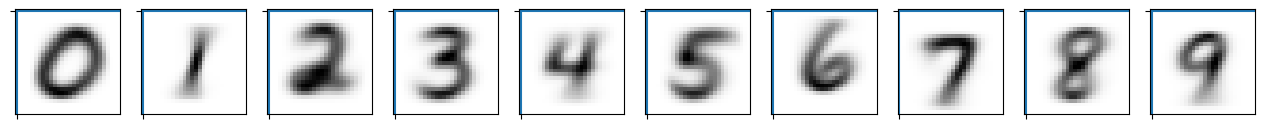

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 10
plt.figure(figsize=(16, 6))
for i in range(0, sample_size):
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(testClassifier.means[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

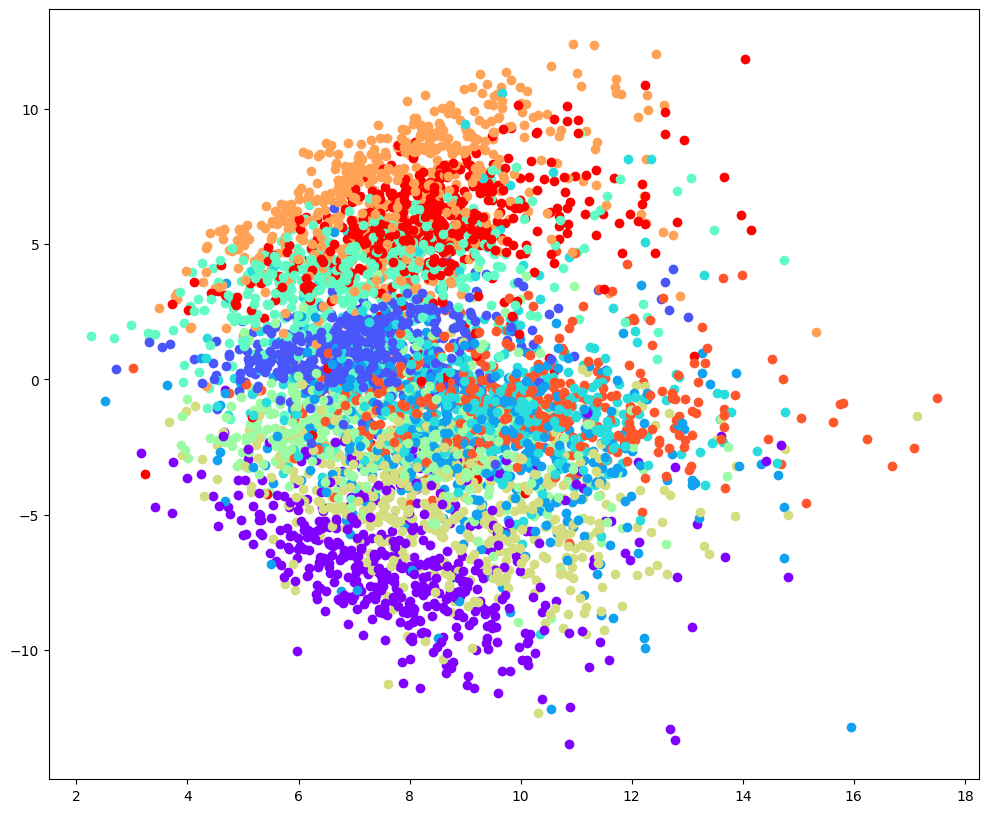

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(testClassifier.classes)))
plotlabels = {testClassifier.classes[c] : colors[c] for c in range(len(testClassifier.classes))}

plt.figure(figsize=(12,10))
for i, point in enumerate(testClassifier.projectedData[:5000]):
    plt.scatter(point[0], point[1], color=plotlabels[testClassifier.td.iloc[i].label])

plt.show()

0.4969


C:\Users\timmy\OneDrive\GradSchool\MachineLearning\mnistExample\lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


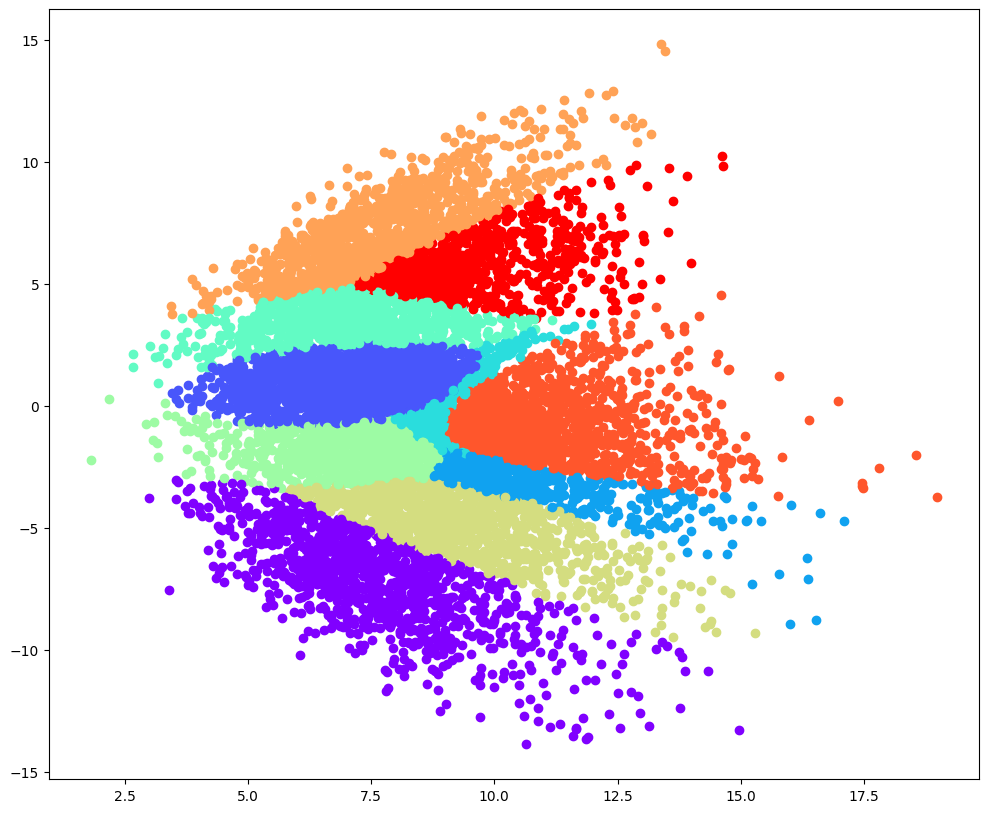

In [208]:
print(accuracy)
classes = testClassifier.classes
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
plotlabels = {classes[c] : colors[c] for c in range(len(classes))}

plt.figure(figsize=(12,10))
for point,pred in zip(projectedData,predictions):
  plt.scatter(point[0],point[1],color=plotlabels[pred])
plt.show()

In [9]:
np.set_printoptions(threshold=10000)
print(testClassifier.w.imag)

[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-5.23017097e-03  3.76871818e-01]
 [ 5.23017097e-03 -3.76871818e-01]
 [-1.99865565e-02  2.12021232e-02]
 [ 1.99865565e-02 -2.12021232e-02]
 [-1.26000898e-02  7.75298016e-02]
 [ 1.26000898e-02 -7.75298016e-02]
 [-1.40547136e-02 -1.07028404e-01]
 [ 1.40547136e-02  1.07028404e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-2.81313031e-02 -1.72828685e-01]
 [ 2.81313031e-02  1.72828685e-01]
 [-1.86619955e-02  1.12190725e-02]
 [ 1.86619955e-02 -1.12190725e-02]
 [-5.52268882e-02 -2.69239261e-02]
 [ 5.52268882e-02  2.69239261e-02]
 [ 7.64912254e-03 -2.16405111e-02]
 [-7.64912254e-03  2.16405111e-02]
 [ 0.00000000e+00  0.00000000e+00]
 [ 6.71485972e-02  7.38412797e-02]
 [-6.71485972e-02 -7.38412797e-02]
 [ 0.00000000e+00  0.00000000e+00]
 [ 1.36817789e-02 -2

In [128]:
print(testClassifier.projectedMeans)

[[ 0.77092695  0.15606984]
 [ 0.69448561  0.03007451]
 [ 0.89281734  0.10710255]
 [ 0.92966587 -0.05831664]
 [ 0.6547496  -0.0385504 ]
 [ 0.78769937  0.09524358]
 [ 0.79795164  0.34482481]
 [ 0.81259781 -0.4552156 ]
 [ 0.97108283  0.06612616]
 [ 0.81166618 -0.25751873]]
